In [5]:
import pickle
from tqdm import tqdm_notebook
from joblib import Parallel, delayed
import requests

# для сбора лайков/дизлайков
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
from youtube_data import youtube_search

# Это просто теория:

### Для работы подключаем YouTube Data API
* [пошаговая инструкция](https://medium.com/greyatom/youtube-data-in-python-6147160c5833)
* [документация](https://developers.google.com/youtube/v3/getting-started)

* [далее пользуемся инструкцией коллег из России](https://nbviewer.jupyter.org/github/DmitrySerg/top-russian-music/blob/master/parsers/clean_youtube_parser.ipynb)

* [и Индии](https://github.com/sudharsanasai/YoutubeDataAnalysis/blob/master/Youtube%20Data.ipynb)

In [7]:
with open('C:/Users/Asus/GitHab_repos/lections/MAIN HELPER/YT_api_key.txt') as f:
    api_key = f.read()

**Отправляем запрос серверу YouTube:**

In [8]:
base_search_url = 'https://www.googleapis.com/youtube/v3/search?'
url = base_search_url+'key={}&channelId={}&part=snippet,id&order=date&maxResults=25'.format(api_key, "UCs6h0i7chZZX3fWD4IOh1kQ")
req = requests.get(url)
req

<Response [200]>

Получаем `<Response [200]>` — [восторг!](https://developer.mozilla.org/ru/docs/Web/HTTP/Status/200)

### [Пробуем Индийские разработки:](https://github.com/sudharsanasai/YoutubeDataAnalysis/blob/master/Youtube%20Data.ipynb)

**сделаем тестовый запрос и сложим данные в таблицу `pandas`**

In [15]:
test = youtube_search("LIZER")
test_df = pd.DataFrame(data=test)
test_df.head(2)

tags  \
0  [lizer, лизер, пачка сигарет, клип, премьера, ...   
1  [lizer, лизер, пачка сигарет, клип, премьера, ...   

                  channelId channelTitle categoryId  \
0  UCBTBuFX6dQ1obb28--d7nmw        LIZER         10   
1  UCBTBuFX6dQ1obb28--d7nmw        LIZER         10   

                                        title      videoId viewCount  \
0                          LIZER — Между Нами  dfPBOt_rhdw  13962266   
1  LIZER  - Пачка Сигарет (prod. by boyfifty)  c_tSDJD1Jf8  16411349   

  likeCount dislikeCount commentCount favoriteCount  
0    429395        10693        13504             0  
1    413624        22481        26061             0

In [16]:
# запишем ценное:
test_df.to_csv('LIZER_info')

### Все отработало здорово, пора исследовать. Берем код русских коллег:

In [11]:
def get_all_video_in_channel(channel_id, api_key):
    """
    Достаёт словарь из id и имен всех видео с канала по его id
        channel_id : string
            id канала
        api_key : string
            ключ доступа к API
    """

    base_search_url = 'https://www.googleapis.com/youtube/v3/search?'
    
    first_url = base_search_url+'key={}&channelId={}&part=snippet,id&order=date&maxResults=25'.format(api_key, channel_id)

    video_links = { }
    url = first_url
    while True:
        req = requests.get(url)
        resp = req.json()

        for i in resp['items']:
            if i['id']['kind'] == "youtube#video":
                video_links.update({i['id']['videoId'] : i['snippet']['title']})

        try:
            next_page_token = resp['nextPageToken']
            url = first_url + '&pageToken={}'.format(next_page_token)
        except:
            break
    return video_links


def get_all_video_in_playlist(playlist_id, api_key):
    """
    Достаёт словарь из id и имен всех видео с плейлиста по его id
        playlist_id : string
            id канала
        api_key : string
            ключ доступа к API
    """

    base_search_url = 'https://www.googleapis.com/youtube/v3/playlistItems?'
    
    first_url = base_search_url+'key={}&playlistId={}&part=id,snippet&order=date&maxResults=25'.format(api_key, playlist_id)

    video_links = { }
    url = first_url
    while True:
        req = requests.get(url)
        resp = req.json()

        for i in resp['items']:
            if i['snippet']['resourceId']['kind'] == "youtube#video":
                video_links.update({i['snippet']['resourceId']['videoId'] : i['snippet']['title']})

        try:
            next_page_token = resp['nextPageToken']
            url = first_url + '&pageToken={}'.format(next_page_token)
        except:
            break
    return video_links


def get_comment_threads(video_id, api_key, style, performer, video_dict, limit=2000):
    """
    Достёт из-под видео 500 комментов
        video_id : string 
            id видяшки
        api_key : string
            ключ доступа к API 
        style : string
            стиль музыки 
        performer : string
            исполнитель
        video_divt : dict
            словарь с соответствием id и названий видео
    """

    base_search_url = 'https://www.googleapis.com/youtube/v3/commentThreads?'
    first_url = base_search_url+'key={}&videoId={}&part=snippet&maxResults=100&textFormat=plainText'.format(api_key, video_id)

    com_inf = [ ]
    url = first_url

    while len(com_inf) < limit:
        req = requests.get(url)
        resp = req.json()

        for item in resp['items']:
            comment = item["snippet"]["topLevelComment"]
            if comment['kind'] == 'youtube#comment':
                cur_infa = {
                    'music_style' : style,
                    'performer' : performer,
                    'video_name' : video_dict[video_id],
                    'comment_id' : comment["id"],
                    'author' : comment["snippet"]["authorDisplayName"],
                    'text' : comment["snippet"]["textDisplay"],
                    'date' : comment["snippet"]['publishedAt'],
                    'likes' : comment["snippet"]['likeCount']
                }

                com_inf.append(cur_infa)       
        try:
            next_page_token = resp['nextPageToken']
            url = first_url + '&pageToken={}'.format(next_page_token)
        except:
            break    
    return com_inf

In [12]:
# делаем словарь, в который соберем комментарии
comments_dict = { }

### Получено:

In [ ]:

{
        'FACE' : {'канал': 'UCQpkqJ4bgocF5bwQsh-qHgg', 'листы': [
        'PL8PKfvXoO2-4NSEg5PBIfhpaHYh3HjPoy', 
        'PL8PKfvXoO2-7TfxrKbOUwjJ-n1cfkbNug', 
        'PL8PKfvXoO2-4CXqqeZPhGHRJ_pj6gWeUp'
    ]}
}


{
     'элджей' : {'канал': 'UCKm_XqwBamWfKBrwAZjmQGw', 'листы': [
        'PL79bk7Abmp0HzP2UdMLkhy_ZlKmiTQwzS', 
        'PL79bk7Abmp0H4z_qVFXLsL-T0-r3a-Hjp', 
        'PL79bk7Abmp0GBUgsOeh5RNH2fMTQRvzMj'
    ]}
 
    
{
     'ATL' : {'канал': 'UCxTuL5Rh8xDSD4IcYhthaaQ', 'листы': [
        'PLM0JG_nxoTpEPxauR-3B3FKCdh2-quiEo',
        'PLM0JG_nxoTpHjrL4L21u9Wl1quGv_9rQk', 
        'PLM0JG_nxoTpHWwTfBbKYsn-1BSef3gccK'
    ]}
    
#  качаю в 2 захаода, тк в первом скачано тольк 2700 комментов + 2700
{
    'ATL' : {'канал': 'UCxTuL5Rh8xDSD4IcYhthaaQ', 'листы': [
        'PLM0JG_nxoTpH1CKjJ7Z1YqvXQLf3y12mE',
        'PLM0JG_nxoTpH7gH_M4VWYi2-3ttmGH_uP',  
    
}

#         здесь хавтит одного плейлиста 66000 comments
{
     'oxxxymironofficial' : {'канал': 'UCCzp3DWpSc0s5wXYDghjM9A', 'листы': [
        'PLI80dHrUcwa0AeGn72hRzCPQGizU_8HbK'
    ]}
}

# 20 000        
{
     'antoha' : {'канал': 'UCKLObxxmmAN4bBXdRtdqEJA', 'листы': [
        'PL4nLGYL7NdIPtOEpZJlBaMcKI6aUfvPmZ'
    ]}
}
# еще Антоха
        
{
     'antoha' : {'канал': 'UCKLObxxmmAN4bBXdRtdqEJA', 'листы': [
        'PL4nLGYL7NdIPS1thwiDFIaJO09Nkbg8Fn'
    ]}
}     
        
        
{
     'MORGENSHTERN' : {'канал': 'UCWnqnojAgMdN0fQpr_xByJw', 'листы': [
        'PL7pohNIwKOU5GEODxQeASFbC6NyFXsur_'
    ]}
}

## А этот не очереди:

In [17]:
style = 'rus-hip-hop'

target = {
     'LIZER' : {'канал': 'PLFM6Pvpc8YQ9IQeZAsgxsFrhoji90ieZL', 'листы': [
        'PLFM6Pvpc8YQ_nq8x_wdt0hu0CWRryLcNO'
    ]}
}

In [18]:
for performer in target.keys():
    print('Качаю {}'.format(performer))
    
    channel_id = target[performer]['канал']
    playlist_ids =  target[performer]['листы']

    # видосы с основного канала 
    video_chanel = get_all_video_in_channel(channel_id, api_key)

    # видосы с плейлистов
    video_playlist = { }
    for lst in playlist_ids:
        video_playlist.update(get_all_video_in_playlist(lst, api_key))

    print('Видео с канала:',len(video_chanel))
    print('Видео с плейлиста:',len(video_playlist))
    video_playlist.update(video_chanel)
    print('Видео всего:',len(video_playlist))
    
    # пошли комменты
    def getCom(x):
        try:
            return get_comment_threads(x, api_key, style, performer, video_playlist)
        except:
            print('Error in https://www.youtube.com/watch?time_continue=1&v={}'.format(x))
            return [ ]

    n_jobs = -1 # параллелим на все ядра 
    result = Parallel(n_jobs=n_jobs)(delayed(getCom)(
        text) for text in tqdm_notebook(list(video_playlist.keys())))
    
    comments = [ ]
    for item in result:
        comments.extend(item)

    print('Добыто комментариев', len(comments))
    
    # воткнуть сюда сохранялку
    comments_dict[performer] = comments
    with open('LIZER.pickle', 'wb') as f:
        pickle.dump(comments_dict, f)
    
    print("==================================================")

Качаю LIZER


KeyError: 'items'

**Складываю всё в переменную `eldjei_full_comments`**

In [20]:
MORGENSHTERN_comments_YouTube = [ ]
for item in comments_dict:
    MORGENSHTERN_comments_YouTube.extend(comments_dict[item])
  
len(MORGENSHTERN_comments_YouTube)

103944

**Посмотрим на информаицю(она храниться в словаре) в комментарий номер 9000:**

In [21]:
MORGENSHTERN_comments_YouTube[9000]

{'music_style': 'rus-hip-hop',
 'performer': 'MORGENSHTERN',
 'video_name': 'ФИНАЛ БИТВЫ КЛИПОВ! Школьник ПРОТИВ Рэпера',
 'comment_id': 'UgxsR4HmEVGto9SA_cV4AaABAg',
 'author': 'Polina Mur',
 'text': 'Больше со школьником и Алишером  нравится, чем у Данила 😽',
 'date': '2019-12-01T12:59:34.000Z',
 'likes': 1}

**Чтобы обратиться к тексту комментария используем конструкцию:**

In [36]:
eldjei_comments_YouTube[9000]['text']

'Лёха респект'

In [41]:
# количество лайков соответственно:
eldjei_comments_YouTube[9000]['likes']

0

**Чтобы посчитать сколько лайков поставили фанаты Элджея друг другу используем конструкцию цикла:**

In [42]:
# сначала обяв
total_likes = 0
for comment in eldjei_comments_YouTube:
    total_likes += comment['likes']

In [47]:
total_likes

458739

### Соберем данные в таблицу (без `comment_id`):

In [23]:
# обращаюсь к методам pandas

MORGENSHTERN_comments_YouTube = pd.DataFrame(MORGENSHTERN_comments_YouTube,
             
# выбираю столбцы  
             
             columns=['music_style', 'performer', 'video_name', 'author', 'text', 'date', 'likes'])
           
             

In [39]:
MORGENSHTERN_comments_YouTube.head(30)

music_style     performer  \
0   rus-hip-hop  MORGENSHTERN   
1   rus-hip-hop  MORGENSHTERN   
2   rus-hip-hop  MORGENSHTERN   
3   rus-hip-hop  MORGENSHTERN   
4   rus-hip-hop  MORGENSHTERN   
5   rus-hip-hop  MORGENSHTERN   
6   rus-hip-hop  MORGENSHTERN   
7   rus-hip-hop  MORGENSHTERN   
8   rus-hip-hop  MORGENSHTERN   
9   rus-hip-hop  MORGENSHTERN   
10  rus-hip-hop  MORGENSHTERN   
11  rus-hip-hop  MORGENSHTERN   
12  rus-hip-hop  MORGENSHTERN   
13  rus-hip-hop  MORGENSHTERN   
14  rus-hip-hop  MORGENSHTERN   
15  rus-hip-hop  MORGENSHTERN   
16  rus-hip-hop  MORGENSHTERN   
17  rus-hip-hop  MORGENSHTERN   
18  rus-hip-hop  MORGENSHTERN   
19  rus-hip-hop  MORGENSHTERN   
20  rus-hip-hop  MORGENSHTERN   
21  rus-hip-hop  MORGENSHTERN   
22  rus-hip-hop  MORGENSHTERN   
23  rus-hip-hop  MORGENSHTERN   
24  rus-hip-hop  MORGENSHTERN   
25  rus-hip-hop  MORGENSHTERN   
26  rus-hip-hop  MORGENSHTERN   
27  rus-hip-hop  MORGENSHTERN   
28  rus-hip-hop  MORGENSHTERN   
29  rus-hip-hop  MORGENSHTERN   

                                         video_name               author  \
0   ЗАКЛАДКА с Двойным Сюрпризом! / Квест по Городу  геннадий тенненбаум   
1   ЗАКЛАДКА с Двойным Сюрпризом! / Квест по Городу      Ксюшка Наживина   
2   ЗАКЛАДКА с Двойным Сюрпризом! / Квест по Городу             Dimon4ik   
3   ЗАКЛАДКА с Двойным Сюрпризом! / Квест по Городу            ᴛʜᴇᴍᴀxʏᴍᴍ   
4   ЗАКЛАДКА с Двойным Сюрпризом! / Квест по Городу            MAX10PLAY   
5   ЗАКЛАДКА с Двойным Сюрпризом! / Квест по Городу    Максим Задорожный   
6   ЗАКЛАДКА с Двойным Сюрпризом! / Квест по Городу       Николай Шашков   
7   ЗАКЛАДКА с Двойным Сюрпризом! / Квест по Городу        Андрей Ревков   
8   ЗАКЛАДКА с Двойным Сюрпризом! / Квест по Городу  Артишок Конеплодный   
9   ЗАКЛАДКА с Двойным Сюрпризом! / Квест по Городу         Trander Wars   
10  ЗАКЛАДКА с Двойным Сюрпризом! / Квест по Городу       Viktor Forpsov   
11  ЗАКЛАДКА с Двойным Сюрпризом! / Квест по Городу        овсепян ваник   
12  ЗАКЛАДКА с Двойным Сюрпризом! / Квест по Городу  Максим Безфамильный   
13  ЗАКЛАДКА с Двойным Сюрпризом! / Квест по Городу        Данис Салахов   
14  ЗАКЛАДКА с Двойным Сюрпризом! / Квест по Городу        Аннп Макарова   
15  ЗАКЛАДКА с Двойным Сюрпризом! / Квест по Городу             LIL AWER   
16  ЗАКЛАДКА с Двойным Сюрпризом! / Квест по Городу      Selskij Gangsta   
17  ЗАКЛАДКА с Двойным Сюрпризом! / Квест по Городу         Диана Сычева   
18  ЗАКЛАДКА с Двойным Сюрпризом! / Квест по Городу         Диана Сычева   
19  ЗАКЛАДКА с Двойным Сюрпризом! / Квест по Городу          Maksfort 66   
20  ЗАКЛАДКА с Двойным Сюрпризом! / Квест по Городу     Анжелика Паутина   
21  ЗАКЛАДКА с Двойным Сюрпризом! / Квест по Городу     самокатер зяпкин   
22  ЗАКЛАДКА с Двойным Сюрпризом! / Квест по Городу              Byn tik   
23  ЗАКЛАДКА с Двойным Сюрпризом! / Квест по Городу           KitchenBoy   
24  ЗАКЛАДКА с Двойным Сюрпризом! / Квест по Городу                Флокс   
25  ЗАКЛАДКА с Двойным Сюрпризом! / Квест по Городу           The Hacker   
26  ЗАКЛАДКА с Двойным Сюрпризом! / Квест по Городу         Яна Круглова   
27  ЗАКЛАДКА с Двойным Сюрпризом! / Квест по Городу         Яна Круглова   
28  ЗАКЛАДКА с Двойным Сюрпризом! / Квест по Городу                  UTA   
29  ЗАКЛАДКА с Двойным Сюрпризом! / Квест по Городу        Artem Eibogin   

                                                 text  \
0                                Ответь мне пажалуста   
1                                             50.000₽   
2   ты коменты четееш???\nменя зовут дима го клип ...   
3   0:25 моя реакция на то, когда Моргенштерн вмес...   
4                           Походу всё было куплено))   
5   Это так странно звучит. Бля города больше нет ...   
6   Че из этих детей вырастит, вот так вот создают...   
7                                на айос не открывает   
8                                           НАЕЕЕБЩИК   
9                                       Алишер лучший

# [WordCloud](https://www.datacamp.com/community/tutorials/wordcloud-python)

In [55]:
long_comment = " ".join(c_ for c_ in MORGENSHTERN_comments_YouTube.text[:10000])
long_comment = long_comment.lower()
print ("ВСего {} слов на 10 000 комментариев.".format(len(long_comment)))

ВСего 423838 слов на 10 000 комментариев.


### Этот метод можно не использовать

In [59]:
from pymystem3 import Mystem
m = Mystem()
# для существительных - именительный падеж, ед. число
lemmas = m.lemmatize(long_comment)
lemmas

['отвечать',
 ' ',
 'я',
 ' ',
 'пажалуст',
 ' ',
 '50.000',
 '₽',
 ' ',
 'ты',
 ' ',
 'комент',
 ' ',
 'четееш',
 '???',
 '\n',
 'я',
 ' ',
 'звать',
 ' ',
 'дима',
 ' ',
 'го',
 ' ',
 'клип',
 ' ',
 'снимать',
 ' ',
 'я',
 ' ',
 '10',
 ' ',
 'год',
 ' ',
 'я',
 ' ',
 'хотеть',
 ' ',
 'становиться',
 ' ',
 'репир',
 '!!!',
 '\n',
 'плиз',
 ' ',
 'почитай',
 ' ',
 '0',
 ':',
 '25',
 ' ',
 'мой',
 ' ',
 'реакция',
 ' ',
 'на',
 ' ',
 'то',
 ', ',
 'когда',
 ' ',
 'моргенштерн',
 ' ',
 'вместо',
 ' ',
 'клип',
 ', ',
 'начинать',
 ' ',
 'бумага',
 ' ',
 'рекламировать',
 ' ',
 'поход',
 ' ',
 'все',
 ' ',
 'быть',
 ' ',
 'купить',
 ')) ',
 'это',
 ' ',
 'так',
 ' ',
 'странно',
 ' ',
 'звучать',
 '.',
 ' ',
 'бля',
 ' ',
 'город',
 ' ',
 'много',
 ' ',
 'нет',
 ' ',
 'апокалипсис',
 ' ',
 'че',
 ' ',
 'из',
 ' ',
 'этот',
 ' ',
 'ребенок',
 ' ',
 'выращивать',
 ', ',
 'вот',
 ' ',
 'так',
 ' ',
 'вот',
 ' ',
 'создавать',
 ' ',
 'тупой',
 ' ',
 'человек',
 ' ',
 'на',
 ' ',
 'айос',
 ' '

In [63]:
long_comment_for_MORGENSHTERN = ''.join(lemmas).strip()

### Сохранил леммизацию

In [91]:
with open('long_comment_for_MORGENSHTERN', 'wb') as f:
    pickle.dump(long_comment_for_MORGENSHTERN, f)

In [2]:
import pickle

with open('long_comment_for_MORGENSHTERN', 'rb') as f:
    long_comment_for_MORGENSHTERN = pickle.load(f)

In [7]:
from stop_words import get_stop_words
stop_words = get_stop_words('russian')

In [8]:
# добавляю свои стоп-слова
stop_words.extend(["алишер", "моргенштерн", "бля",'видео', 'морген', 'блять', 'нахуй', 'https', 'youtu', 'клип', 'муда', 'сука'])

### строим WordCloud

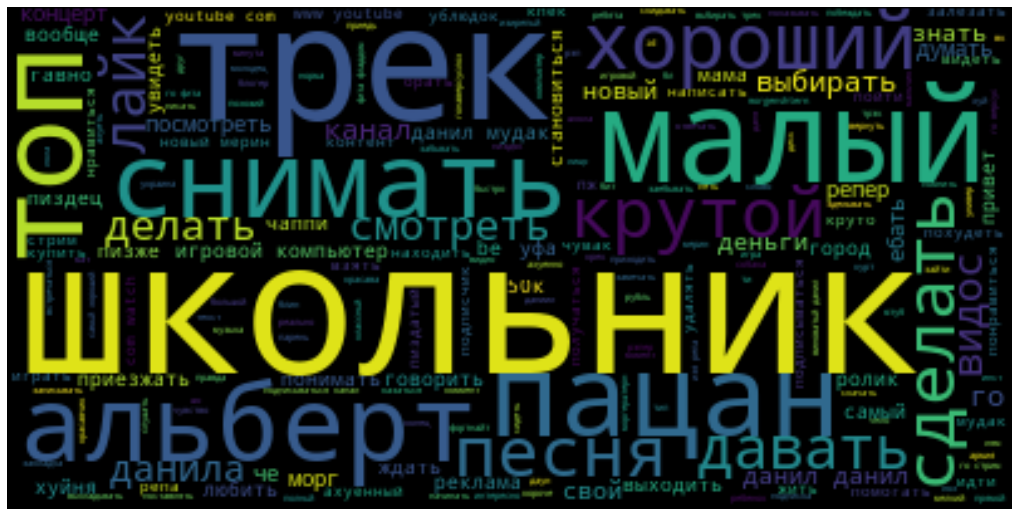

In [12]:
from os import path
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

wordcloud = WordCloud(stopwords=stop_words).generate(long_comment_for_MORGENSHTERN)

# Display the generated image:
plt.figure(figsize=(18,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig("long_comment_for_MORGENSHTERN.png", dpi=300) 
plt.show()

# надо еще проверить на частотность

# ОТКРЫВАЕМ ФАЙЛЫ ДЛЯ РАБОТЫ:

In [43]:
# открываем наши файлы через pandas
eldjei_comments_YouTube = pd.read_pickle("eldjei_comments_YouTube.pickle")
FACE_comments_YouTube = pd.read_pickle("FACE_comments_YouTube.pickle")

eldjei_comments_YouTube

{'элджей': [{'music_style': 'rus-hip-hop',
   'performer': 'элджей',
   'video_name': 'SAYONARA BOY FW 19/20',
   'comment_id': 'UgxNzjButrLZAMtxvpx4AaABAg',
   'author': 'The Best',
   'text': 'Этим можно мазаться!',
   'date': '2019-12-16T20:25:24.000Z',
   'likes': 0},
  {'music_style': 'rus-hip-hop',
   'performer': 'элджей',
   'video_name': 'SAYONARA BOY FW 19/20',
   'comment_id': 'UgxVhIuKjmeAOc9wuU54AaABAg',
   'author': 'The Best',
   'text': 'Здесь есть такие люди, которые реально фанаты Элджея, и которым не раз говорили:" Элджей - ГОВНО!!!"?',
   'date': '2019-12-16T20:22:35.000Z',
   'likes': 1},
  {'music_style': 'rus-hip-hop',
   'performer': 'элджей',
   'video_name': 'SAYONARA BOY FW 19/20',
   'comment_id': 'Ugyc7mtkh69KPlSw7KF4AaABAg',
   'author': 'The Best',
   'text': 'Я надеюсь это будет в рекламе на ТВ!',
   'date': '2019-12-16T20:20:30.000Z',
   'likes': 1},
  {'music_style': 'rus-hip-hop',
   'performer': 'элджей',
   'video_name': 'SAYONARA BOY FW 19/20',
   

#### Повтаряем действия с формированием таблиц:

In [45]:
eldjei_data = [ ]
for item in eldjei_comments_YouTube:
    eldjei_data.extend(eldjei_comments_YouTube[item])
  
len(eldjei_data)

73607

In [46]:
eldjei_data = pd.DataFrame(eldjei_data,
             
# выбираю столбцы  
             
             columns=['music_style', 'performer', 'video_name', 'author', 'text', 'date', 'likes'])
           
eldjei_data.head()           

music_style performer             video_name            author  \
0  rus-hip-hop    элджей  SAYONARA BOY FW 19/20          The Best   
1  rus-hip-hop    элджей  SAYONARA BOY FW 19/20          The Best   
2  rus-hip-hop    элджей  SAYONARA BOY FW 19/20          The Best   
3  rus-hip-hop    элджей  SAYONARA BOY FW 19/20  Динар Киньябузов   
4  rus-hip-hop    элджей  SAYONARA BOY FW 19/20        Котайн топ   

                                                text  \
0                               Этим можно мазаться!   
1  Здесь есть такие люди, которые реально фанаты ...   
2               Я надеюсь это будет в рекламе на ТВ!   
3                                           Не о чём   
4                              Тоооооооооппппп!!!!!!   

                       date  likes  
0  2019-12-16T20:25:24.000Z      0  
1  2019-12-16T20:22:35.000Z      1  
2  2019-12-16T20:20:30.000Z      1  
3  2019-12-16T15:10:29.000Z      0  
4  2019-12-16T06:07:14.000Z      0

## [Применим знания из лекции:](https://nbviewer.jupyter.org/github/FUlyankin/HSE_Data_Culture/blob/master/ML_for_marketing_2019/sems/sem1%262_data_prepare/sem1_sells.ipynb)

In [48]:
eldjei_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73607 entries, 0 to 73606
Data columns (total 7 columns):
music_style    73607 non-null object
performer      73607 non-null object
video_name     73607 non-null object
author         73607 non-null object
text           73607 non-null object
date           73607 non-null object
likes          73607 non-null int64
dtypes: int64(1), object(6)
memory usage: 3.9+ MB


In [2]:
import re
a_list = ['🤔!!! 🙈 me así, bla es// 88se 😌 ds 💕👭👙']
re.findall(r'[^\w\s,]', a_list[0])

['🤔', '!', '!', '!', '🙈', '/', '/', '😌', '💕', '👭', '👙']